In [1]:
from collections import Counter, defaultdict
from itertools import combinations
import pandas as pd
import numpy as np
import operator
import math
import itertools
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import norm
%matplotlib inline
import seaborn as sns
import pymc as pm
import arviz as az

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
PK = pd.read_csv('Penalty Kills (2015-2024).csv')
Pens = pd.read_csv('2023-24 NHL Penalty Counts.csv')

In [3]:
Pens.head()

,Game ID,Team,Penalties Committed,Penalties Drawn,Penalty Diff
0,2023020001,NSH,6,4,2
1,2023020001,TBL,4,6,-2
2,2023020002,PIT,4,2,2
3,2023020002,CHI,2,4,-2
4,2023020003,SEA,4,4,0


In [4]:
PK.head()

,teamFullName,seasonId,penaltyKillPct,ppGoalsAgainst,shGoalsFor,timesShorthanded,Penalties Killed
0,Buffalo Sabres,20172018,0.77872,52,9,235.0,183.0
1,Detroit Red Wings,20192020,0.74336,58,4,226.0,168.0
2,Chicago Blackhawks,20152016,0.79681,51,11,251.0,200.0
3,Washington Capitals,20212022,0.81893,44,8,243.0,199.0
4,Montréal Canadiens,20232024,0.76706,58,5,249.0,191.0


In [5]:
PK_thisSzn = PK[PK['seasonId'] == 20232024]

In [6]:
PK_thisSzn[['teamFullName', 'timesShorthanded', 'Penalties Killed']].head()

,teamFullName,timesShorthanded,Penalties Killed
4,Montréal Canadiens,249.0,191.0
5,San Jose Sharks,230.0,173.0
10,Carolina Hurricanes,239.0,205.0
26,New Jersey Devils,220.0,179.0
43,Toronto Maple Leafs,210.0,163.0


In [7]:
# Array of all 32 teams
teamAbbrev = sorted(Pens['Team'].unique())
teamAbbrev[:5]

['ANA', 'ARI', 'BOS', 'BUF', 'CAR']

In [8]:
PK_thisSzn.head()

,teamFullName,seasonId,penaltyKillPct,ppGoalsAgainst,shGoalsFor,timesShorthanded,Penalties Killed
4,Montréal Canadiens,20232024,0.76706,58,5,249.0,191.0
5,San Jose Sharks,20232024,0.75217,57,3,230.0,173.0
10,Carolina Hurricanes,20232024,0.85774,34,10,239.0,205.0
26,New Jersey Devils,20232024,0.81363,41,3,220.0,179.0
43,Toronto Maple Leafs,20232024,0.77619,47,6,210.0,163.0


# EDA

Text(0.5, 1.0, 'Penalty Difference for the Carolina Hurricanes in 2023-24')

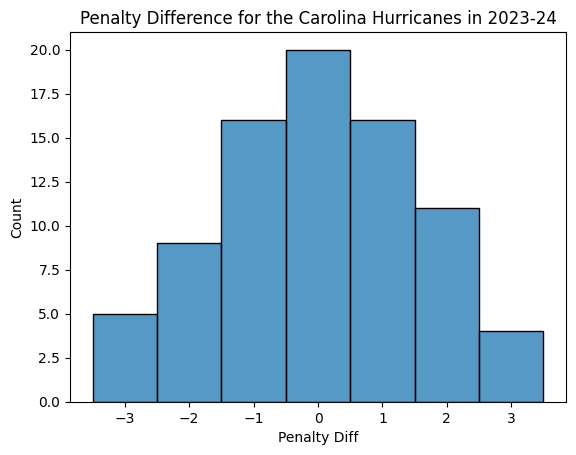

In [9]:
sns.histplot(data = Pens[Pens['Team'] == 'CAR'],
            x = 'Penalty Diff',
             bins = np.arange(-3.5,4.5,1))
plt.title('Penalty Difference for the Carolina Hurricanes in 2023-24')

In [10]:
# Get data from last season, then isolate desired columns, then get sums
PK[PK['seasonId'] == 20222023][['timesShorthanded', 'Penalties Killed']].sum()

timesShorthanded    8600.0
Penalties Killed    6753.0
dtype: float64

Text(0.5, 1.0, 'Prior Distribution is Based off PK Data From 2022-2023')

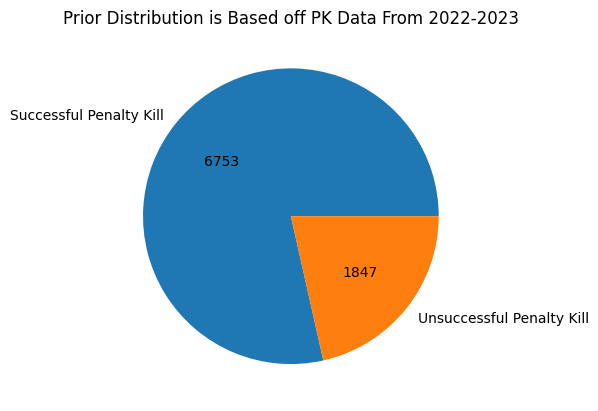

In [11]:
plt.pie([6753, 8600 - 6753], labels = ['Successful Penalty Kill', 'Unsuccessful Penalty Kill'],
        autopct= lambda x:round(x*8600/100));#'%.0f%%');
plt.title('Prior Distribution is Based off PK Data From 2022-2023')

In [12]:
# Sum of 2023-2024 penalty counts per team
grouped_sum = Pens.groupby(by='Team').sum().sort_values('Penalties Drawn')
print(grouped_sum.shape[0])
grouped_sum.head()

# Average of 2023-2024 penalty counts per team
grouped_mean = Pens.groupby(by='Team').mean().sort_values('Penalty Diff')
print(grouped_mean.shape[0])
grouped_mean.head()

32
32


,Game ID,Penalties Committed,Penalties Drawn,Penalty Diff
Team,,,,
VGK,2.023021e+09,3.036585,3.573171,-0.536585
DET,2.023021e+09,3.817073,4.317073,-0.500000
STL,2.023021e+09,3.219512,3.634146,-0.414634
OTT,2.023021e+09,4.158537,4.500000,-0.341463
WPG,2.023021e+09,3.353659,3.634146,-0.280488


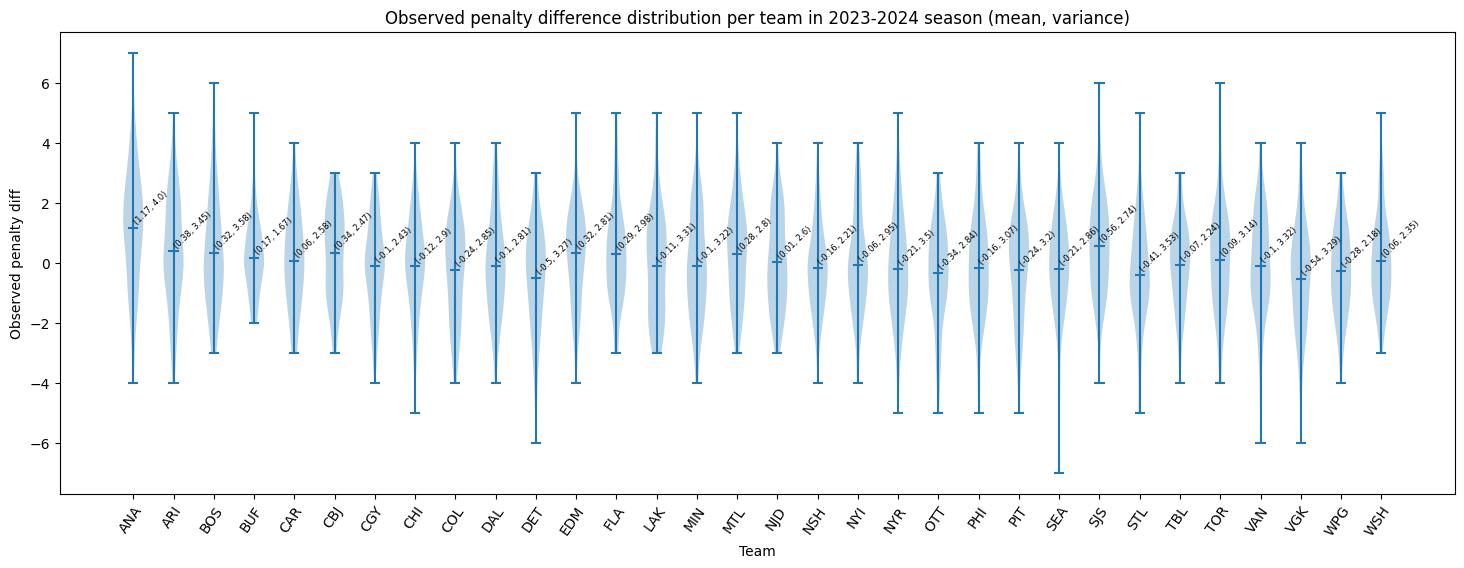

In [13]:
# Grouping 2023-2024 penalty dataset by team, then aggregating observed penalty difference values into numpy array
grouped_diff = Pens.set_index('Team').groupby('Team')['Penalty Diff'].apply(np.array)
grouped_diff_means = Pens.groupby('Team')['Penalty Diff'].mean().round(2)
grouped_diff_vars = Pens.groupby('Team')['Penalty Diff'].var().round(2)
params = [w for w in zip(grouped_diff_means, grouped_diff_vars)]

fig, ax = plt.subplots(figsize=(18,6))

ax.violinplot(grouped_diff, showmeans=True)
ax.set_xticks(np.arange(1,33), grouped_diff.index)
ax.set_xlabel('Team')
ax.set_ylabel('Observed penalty diff')
ax.set_title('Observed penalty difference distribution per team in 2023-2024 season (mean, variance)')
plt.setp(ax.get_xticklabels(), rotation=55, ha="right", rotation_mode='anchor')

for i, v in enumerate(params):
  plt.text((i+1.1), (v[0]+0.1), str(v), fontsize=6, rotation=45, rotation_mode='anchor')

fig.show()

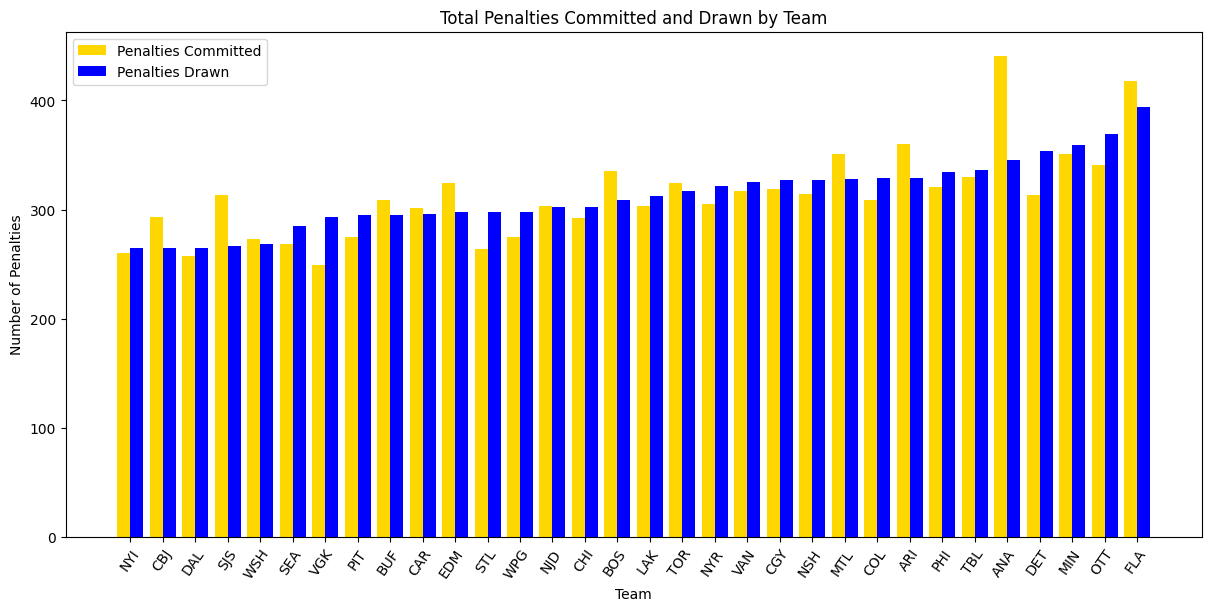

In [14]:
fig, ax = plt.subplots(figsize=(12, 6), layout='constrained')

width = 0.4
teams = np.arange(len(grouped_sum.index))

ax.bar(teams - 0.2, grouped_sum['Penalties Committed'], width, label='Penalties Committed', color='gold')
ax.bar(teams + 0.2, grouped_sum['Penalties Drawn'], width, label='Penalties Drawn', color='blue')
ax.set_xlabel('Team')
ax.set_ylabel('Number of Penalties')
ax.set_title('Total Penalties Committed and Drawn by Team')
ax.set_xticks(teams, grouped_sum.index)
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=55, ha="right", rotation_mode='anchor')

plt.show()

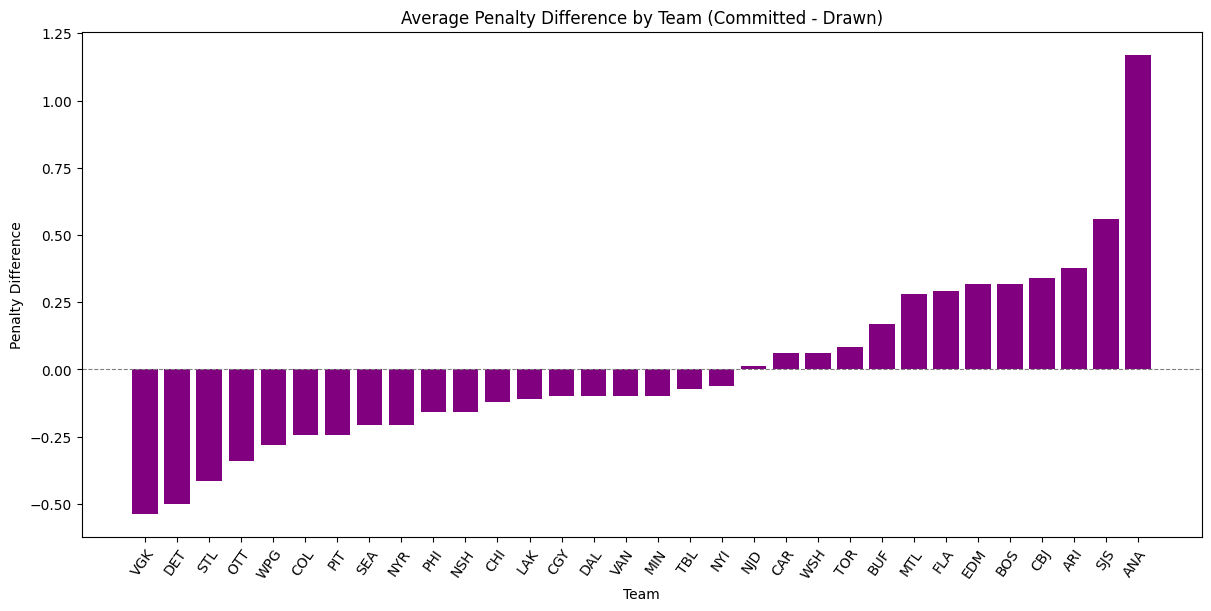

In [15]:
fig, ax = plt.subplots(figsize=(12, 6), layout='constrained')

ax.bar(grouped_mean.index, grouped_mean['Penalty Diff'], color='purple')
ax.axhline(0, color='grey', linewidth=0.8, linestyle = 'dashed')
ax.set_title('Average Penalty Difference by Team (Committed - Drawn)')
ax.set_xlabel('Team')
ax.set_ylabel('Penalty Difference')
plt.setp(ax.get_xticklabels(), rotation=55, ha="right", rotation_mode='anchor')
plt.show()

# Bayesian Hierarchical Modeling

In [16]:
# Using values from the past season for our prior
prior_vals = PK[(PK['seasonId'] == 20222023)][['Penalties Killed','timesShorthanded']].sum()
alpha, beta = prior_vals['Penalties Killed'], prior_vals['timesShorthanded'] - prior_vals['Penalties Killed']
alpha//32, beta//32

(211.0, 57.0)

In [17]:
with pm.Model() as model:
    a = pm.Uniform('a', lower = 0, upper = alpha//32)
    b = pm.Uniform('b', lower = 0, upper = beta//32)
    theta = pm.Beta('theta', alpha = a, beta = b, shape = len(PK_thisSzn))
    X = pm.Binomial('X', p = theta, observed = PK_thisSzn['Penalties Killed'], n = PK_thisSzn['timesShorthanded'])
    trace = pm.sample(500, chains=4, tune=1000, target_accept=0.95, return_inferencedata=False, progressbar=False, random_seed = 7)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [a, b, theta]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 82 seconds.


In [18]:
thetas = trace['theta']
thetas.shape

(2000, 32)

In [19]:
hdi_95 = az.hdi(trace['theta'], hdi_prob = .95)

/tmp/ipykernel_236/1370843802.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_95 = az.hdi(trace['theta'], hdi_prob = .95)


In [20]:
hdi_df = pd.DataFrame([{'Team': team, '95% HDI Lower': hdi[0], '95% HDI Upper': hdi[1]} for team, hdi in zip(PK_thisSzn['teamFullName'], hdi_95)])
hdi_df.head()

,Team,95% HDI Lower,95% HDI Upper
0,Montréal Canadiens,0.739449,0.817035
1,San Jose Sharks,0.732364,0.810350
2,Carolina Hurricanes,0.789880,0.857857
3,New Jersey Devils,0.765318,0.842207
4,Toronto Maple Leafs,0.745296,0.823975


In [21]:
estimates = pd.DataFrame(thetas, columns = PK_thisSzn['teamFullName']).melt(value_vars = PK_thisSzn['teamFullName'])
estimates.rename(columns = {'teamFullName':'Team'}, inplace = True)
estimates.head()

,Team,value
0,Montréal Canadiens,0.769882
1,Montréal Canadiens,0.799354
2,Montréal Canadiens,0.759688
3,Montréal Canadiens,0.772681
4,Montréal Canadiens,0.778386


In [22]:
hdi_df = hdi_df.merge(estimates.groupby('Team')['value'].mean().reset_index()).rename(columns = {'value':'Mean'})
hdi_df.sort_values('Mean', ascending = False).head()

,Team,95% HDI Lower,95% HDI Upper,Mean
2,Carolina Hurricanes,0.789880,0.857857,0.826501
18,Los Angeles Kings,0.783993,0.854887,0.820587
26,Philadelphia Flyers,0.780326,0.854714,0.815671
29,New York Rangers,0.775074,0.851298,0.813535
11,Tampa Bay Lightning,0.773767,0.848478,0.810802


Text(0.5, 1.0, 'Theta Estimates of Top Five Penalty Killing Teams in the NHL')

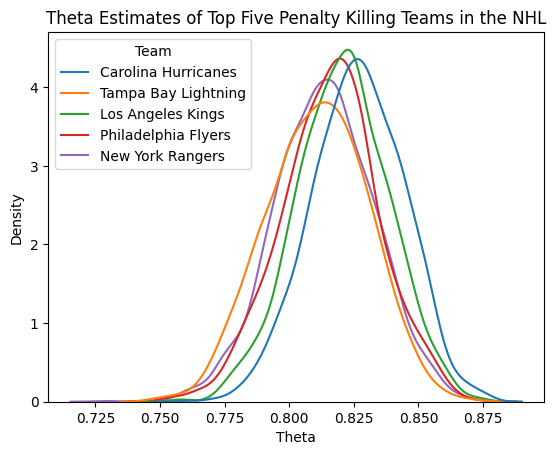

In [23]:
def filterByTeams(*args):
    return estimates[estimates['Team'].isin(args)]
sns.kdeplot(data = filterByTeams('Carolina Hurricanes', 'Los Angeles Kings', 'Philadelphia Flyers', 'New York Rangers', 'Tampa Bay Lightning'), x = 'value', hue = 'Team')
plt.xlabel('Theta')
plt.title('Theta Estimates of Top Five Penalty Killing Teams in the NHL')

# Hypothesis Testing pt 1

In [24]:
num_simulations = 1000
alpha = .05 # Desired TPR

In [25]:
# To ensure replicability (seed is set to 7 cuz that's my fav number)
rng = np.random.default_rng(seed = 7)
# Generate a certain amount of random states for each team for A/B testing
random_states = rng.integers(low = 1, high = (2**32) - 1, size = 32*num_simulations)

In [26]:
# Store actual penalties/game for a team - mean penalties/game for the other teams
penDiff = lambda team, df: df[df['Team'] == team]['Penalties Committed'].mean() - df[df['Team'] != team]['Penalties Committed'].mean()
observed ={team: penDiff(team, Pens) for team in teamAbbrev}
observed #You can uncomment this if you wanna see it but it's long so I commented it out

{'ANA': 1.6144767899291894,
 'ARI': 0.594807238394965,
 'BOS': 0.280094413847364,
 'BUF': -0.04720692368214019,
 'CAR': -0.14791502753737218,
 'CBJ': -0.24862313139260417,
 'CGY': 0.07867820613690002,
 'CHI': -0.2612116443745083,
 'COL': -0.04720692368214019,
 'DAL': -0.7018095987411486,
 'DET': 0.0031471282454758054,
 'EDM': 0.14162077104642012,
 'FLA': 1.3249409913453976,
 'LAK': -0.12273800157356396,
 'MIN': 0.4815106215578284,
 'MTL': 0.4815106215578284,
 'NJD': -0.12273800157356396,
 'NSH': 0.015735641227379915,
 'NYI': -0.6640440597954367,
 'NYR': -0.09756097560975574,
 'OTT': 0.3556254917387882,
 'PHI': 0.10385523210070824,
 'PIT': -0.4752163650668768,
 'SEA': -0.5633359559402047,
 'SJS': 0.0031471282454758054,
 'STL': -0.6136900078678202,
 'TBL': 0.21715184893784434,
 'TOR': 0.14162077104642012,
 'VAN': 0.0535011801730918,
 'VGK': -0.8025177025963806,
 'WPG': -0.4752163650668768,
 'WSH': -0.5003933910306846}

In [27]:
p_values = {} # Store into here later
index_start = 0 # For getting seeds
for team in teamAbbrev:
    more_extreme = 0
    for seed in random_states[index_start:index_start + num_simulations]:
        df = Pens.copy()
        df['Team'] = list(df['Team'].sample(frac = 1, replace = False, random_state = seed))
        if (penDiff(team, df) >= observed[team]) and (observed[team] > 0):
            more_extreme += 1
        elif (penDiff(team, df) <= observed[team]) and (observed[team] < 0):
            more_extreme += 1
    p_values[team] = more_extreme/num_simulations
    index_start += num_simulations

In [28]:
p_values

{'ANA': 0.0,
 'ARI': 0.009,
 'BOS': 0.127,
 'BUF': 0.434,
 'CAR': 0.29,
 'CBJ': 0.138,
 'CGY': 0.356,
 'CHI': 0.113,
 'COL': 0.473,
 'DAL': 0.0,
 'DET': 0.493,
 'EDM': 0.273,
 'FLA': 0.0,
 'LAK': 0.333,
 'MIN': 0.02,
 'MTL': 0.025,
 'NJD': 0.322,
 'NSH': 0.491,
 'NYI': 0.001,
 'NYR': 0.351,
 'OTT': 0.07,
 'PHI': 0.32,
 'PIT': 0.014,
 'SEA': 0.004,
 'SJS': 0.49,
 'STL': 0.003,
 'TBL': 0.161,
 'TOR': 0.258,
 'VAN': 0.419,
 'VGK': 0.001,
 'WPG': 0.023,
 'WSH': 0.017}

## Benjamini Hochberg (FDR)

In [29]:
sorted_p_vals = sorted(p_values.values())
k, m, threshold = 32, 32, 0
for p in sorted_p_vals[::-1]:
    if p < (k*alpha/m):
        threshold = p
        break
    k -= 1
BH_verdict = {team: p_values[team] <= threshold for team in teamAbbrev}

In [30]:
threshold

0.014

In [31]:
# Teams to reject
[team for team in teamAbbrev if BH_verdict[team]]

['ANA', 'ARI', 'DAL', 'FLA', 'NYI', 'PIT', 'SEA', 'STL', 'VGK']

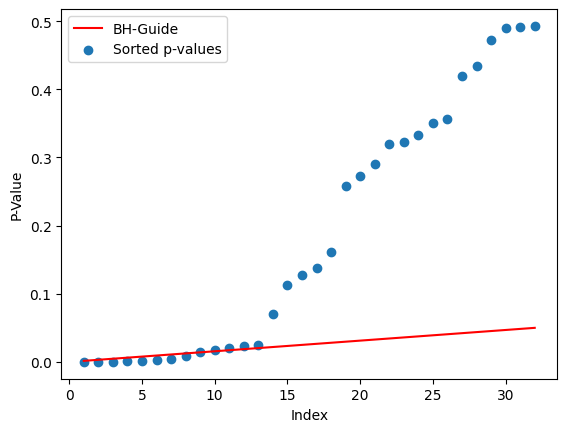

In [32]:
plt.plot([1,32], [alpha/32,alpha], label = 'BH-Guide', color = 'red')
plt.scatter(range(1,33), sorted_p_vals, label = 'Sorted p-values')
plt.xlabel('Index')
plt.ylabel('P-Value')
plt.legend()

## Bonferroni Correction (FWER)

In [33]:
threshold = alpha/m
Bonferroni_verdict = {team: p_values[team] <= threshold for team in teamAbbrev}

In [34]:
threshold

0.0015625

In [35]:
# Teams to reject
[team for team in teamAbbrev if Bonferroni_verdict[team]]

['ANA', 'DAL', 'FLA', 'NYI', 'VGK']

In [36]:
[(team, observed[team]) for team in teamAbbrev if BH_verdict[team] or Bonferroni_verdict[team]]

[('ANA', 1.6144767899291894),
 ('ARI', 0.594807238394965),
 ('DAL', -0.7018095987411486),
 ('FLA', 1.3249409913453976),
 ('NYI', -0.6640440597954367),
 ('PIT', -0.4752163650668768),
 ('SEA', -0.5633359559402047),
 ('STL', -0.6136900078678202),
 ('VGK', -0.8025177025963806)]

# Hypothesis Testing pt 2

In [37]:
LRT_verdict = {} # fill with teams: true if we reject, false if we don't
for team in teamAbbrev:
    penalty_diffs = Pens[Pens['Team'] == team]['Penalty Diff']
    sigma = penalty_diffs.std()
    f1 = lambda T: norm.cdf(T + .5, loc = 1, scale = sigma**2) - norm.cdf(T - .5, loc = 1, scale = sigma**2)
    f0 = lambda T: norm.cdf(T + .5, loc = 0, scale = sigma**2) - norm.cdf(T - .5, loc = 0, scale = sigma**2)
    gamma_prime_alpha = norm.ppf(1 - alpha, loc = 0, scale = sigma) # Threshold for test statistic under the null
    gamma_prime_alpha = (gamma_prime_alpha//1) + (1 if gamma_prime_alpha%1 > 0 else 0) # Round up
    LR = lambda T: f1(T)/f0(T)
    gamma = LR(gamma_prime_alpha)
    LRT = np.prod([LR(x) for x in penalty_diffs])
    LRT_verdict[team] = LRT > gamma # True (reject) if test statistic is higher, False otherwise

In [38]:
LRT_verdict

{'ANA': True,
 'ARI': False,
 'BOS': False,
 'BUF': False,
 'CAR': False,
 'CBJ': False,
 'CGY': False,
 'CHI': False,
 'COL': False,
 'DAL': False,
 'DET': False,
 'EDM': False,
 'FLA': False,
 'LAK': False,
 'MIN': False,
 'MTL': False,
 'NJD': False,
 'NSH': False,
 'NYI': False,
 'NYR': False,
 'OTT': False,
 'PHI': False,
 'PIT': False,
 'SEA': False,
 'SJS': True,
 'STL': False,
 'TBL': False,
 'TOR': False,
 'VAN': False,
 'VGK': False,
 'WPG': False,
 'WSH': False}

In [39]:
[team for team in teamAbbrev if LRT_verdict[team]]

['ANA', 'SJS']